In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from  scipy.interpolate import interp1d

In [ ]:
prices_dir = "final prices - working"

In [ ]:
gbm_dict = {}
ms_garch_dict = {}
garch_dict = {}
reg_dict = {}
class_dict = {}

unique_dtes_set = set()

for filename in os.listdir(prices_dir):
    if filename.endswith(".npy"):
        if "copy" in filename:
            continue
        dte = int(filename.split(".npy")[0].split("_")[-1])

        unique_dtes_set.add(dte)

        if "gbm" in filename:
            gbm_dict[dte] = np.load(f"{prices_dir}/{filename}")
        elif "ms_garch" in filename:
            ms_garch_dict[dte] = np.load(f"{prices_dir}/{filename}")
        elif "garch" in filename:
            garch_dict[dte] = np.load(f"{prices_dir}/{filename}")
        elif "reg" in filename:
            reg_dict[dte] = np.load(f"{prices_dir}/{filename}")
        elif "class" in filename:
            class_dict[dte] = np.load(f"{prices_dir}/{filename}")
        else:
            print(f"Unknown file type: {filename}")
            continue

unique_dtes = np.array(sorted(list(unique_dtes_set)))

In [23]:
unique_dtes

array([ 1,  3,  4,  5,  6,  9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 23,
       25, 27, 30])

In [24]:
market_prices_df = pd.read_csv(f"{prices_dir}/market_prices.csv")
market_prices_df = market_prices_df[market_prices_df["DTE"].isin(unique_dtes)]

In [25]:
def europe_call_payoff(S, K):
    return np.maximum(S - K, 0)

def europe_put_payoff(S, K):
    return np.maximum(K - S, 0)

def option_price(K, r, N, payoff, final_prices):
    T = N
    discount_factor = np.exp(-r * T)
    option_payoffs = payoff(final_prices, K)
    option_prices = discount_factor * np.mean(option_payoffs)
    return option_prices

In [26]:
class RiskFreeCurve:
    """
    Interpolates a Treasury term‑structure keyed in *trading* days.
    - Stores log‑discount factors (monotone  arbitrage‑free for a normal curve).
    - Linear in log‑D is plenty for money‑market work; swap desks often use
      cubic splines – just swap `interp1d(..., kind="linear")` for CubicSpline.
    """
    TDAYS_PER_YEAR = 252                      # use your firm’s convention
    
    def __init__(self, rf_dict: dict[int, float]):
        # --- pillar data -----------------------------------------------------
        self.t   = np.array(sorted(rf_dict))                        # days
        y        = np.array([rf_dict[d] for d in self.t])           # yields
        self._logD = np.log(np.exp(-y * self.t / self.TDAYS_PER_YEAR))
        # --- interpolator ----------------------------------------------------
        self._ilogD = interp1d(self.t, self._logD,
                               kind="linear",           # or "cubic"
                               fill_value="extrapolate",
                               assume_sorted=True)

    # ---------- user‑facing API ----------------------------------------------
    def discount(self, t: int | float) -> float:
        "DF for any (fractional) trading‑day t"
        return np.exp(self._ilogD(t))
    
    def zero_rate(self, t: int | float) -> float:
        "Continuously‑compounded zero yield"
        return -np.log(self.discount(t)) * self.TDAYS_PER_YEAR / t
    
    __call__ = zero_rate                     # so you can do curve(100)

In [27]:
rf_rates = { #https://tradingeconomics.com/united-states/government-bond-yield - we said we collected this straight from US treasure gov
    30: 4.30 / 100, # 1 month treasury yield
    60: 4.31 / 100, # 2 month treasury yield
    90: 4.31 / 100, # 3 month treasury yield
    180: 4.20 / 100, # 6 month treasury yield
    365: 3.96 / 100, # 1 year treasury yield
    730: 3.75 / 100, # 2 year treasury yield
    1095: 3.74 / 100, # 3 year treasury yield
}

# rf_rates = { # num_trade_days = round(num_real_days * 252 / 365) 
#     21 : 4.38 / 100,
#     41 : 4.36 / 100,
#     62 : 4.42 / 100,
#     124: 4.29 / 100,
#     252: 4.11 / 100,
#     504: 3.98 / 100,
#     756: 3.97 / 100,
# }


curve = RiskFreeCurve(rf_rates)

def get_closest_rate(dte, rf_rates):
    sorted_terms = sorted(rf_rates.keys())
    for term in sorted_terms:
        if dte <= term:
            return rf_rates[term]
    #return curve(dte)
    
#unique_dtes = market_prices_df['DTE'].unique()
dte_risk_free_rates = {dte: get_closest_rate(dte, rf_rates) for dte in unique_dtes}
dte_risk_free_rates

{np.int64(1): 0.043,
 np.int64(3): 0.043,
 np.int64(4): 0.043,
 np.int64(5): 0.043,
 np.int64(6): 0.043,
 np.int64(9): 0.043,
 np.int64(10): 0.043,
 np.int64(11): 0.043,
 np.int64(13): 0.043,
 np.int64(14): 0.043,
 np.int64(15): 0.043,
 np.int64(16): 0.043,
 np.int64(18): 0.043,
 np.int64(19): 0.043,
 np.int64(20): 0.043,
 np.int64(21): 0.043,
 np.int64(23): 0.043,
 np.int64(25): 0.043,
 np.int64(27): 0.043,
 np.int64(30): 0.043}

In [28]:
with open(f"{prices_dir}/S0.txt", "r") as f:
    S0 = float(f.read().strip())
S0

5892.580078125

In [30]:
unique_dtes = np.array(sorted(list(unique_dtes_set)))
#unique_dtes = unique_dtes[unique_dtes > 50]
unique_dtes

array([ 1,  3,  4,  5,  6,  9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 23,
       25, 27, 30])

In [31]:
#np.percentile(abs(all_strikes - S0)/S0, [30, 80])

In [ ]:
comparison_results = []

for index, row in market_prices_df.iterrows():
    dte = row['DTE']
    if dte not in unique_dtes:
        continue
    K = row['strike']

    all_strikes = market_prices_df[market_prices_df['DTE'] == dte]['strike'].values
    

    # b = np.percentile(abs(all_strikes - S0)/S0, [75])
    # if abs(K - S0) / S0 < b: #
    #     continue    


    # if abs(K - S0) < lq or abs(K - S0) > uq: # ATM only
    #     continue

    # if abs(K - S0) > lq and abs(K - S0) < uq: # OTM only
    #     continue

    # if abs((K - S0) / S0) > 0.2:
    #     continue

    #print(K)

    call_market = row["Call_Market_Price"]
    put_market = row["Put_Market_Price"]

    # if call_market == 0 and put_market == 0:
    #     continue

    T = dte/252

    gbm_finals = gbm_dict[dte]
    garch_finals = garch_dict[dte]
    ms_garch_finals = ms_garch_dict[dte]
    reg_finals = reg_dict[dte]
    class_finals = class_dict[dte]

    r = dte_risk_free_rates[dte] 

    call_gbm = option_price(K, r, T, europe_call_payoff, gbm_finals)
    put_gbm = option_price(K, r, T, europe_put_payoff, gbm_finals)
    
    call_garch = option_price(K, r, T, europe_call_payoff, garch_finals)
    put_garch = option_price(K, r, T, europe_put_payoff, garch_finals)

    call_ms_garch = option_price(K, r, T, europe_call_payoff, ms_garch_finals)
    put_ms_garch = option_price(K, r, T, europe_put_payoff, ms_garch_finals)

    call_reg = option_price(K, r, T, europe_call_payoff, reg_finals)
    put_reg = option_price(K, r, T, europe_put_payoff, reg_finals)

    call_class = option_price(K, r, T, europe_call_payoff, class_finals)
    put_class = option_price(K, r, T, europe_put_payoff, class_finals)

    parity_gbm = call_gbm - put_gbm - (S0 - K * np.exp(-r * T))
    parity_garch = call_garch - put_garch - (S0 - K * np.exp(-r * T))
    parity_ms_garch = call_ms_garch - put_ms_garch - (S0 - K * np.exp(-r * T))
    parity_reg = call_reg - put_reg - (S0 - K * np.exp(-r * T))
    parity_class = call_class - put_class - (S0 - K * np.exp(-r * T))
    parity_market = call_market - put_market - (S0 - K * np.exp(-r * T))
    

    call_gbm_diff = call_gbm - call_market
    put_gbm_diff = put_gbm - put_market
    
    call_garch_diff = call_garch - call_market
    put_garch_diff = put_garch - put_market

    call_ms_garch_diff = call_ms_garch - call_market
    put_ms_garch_diff = put_ms_garch - put_market

    call_reg_diff = call_reg - call_market
    put_reg_diff = put_reg - put_market

    call_class_diff = call_class - call_market
    put_class_diff = put_class - put_market

    call_market_diff = call_market - call_market
    put_market_diff = put_market - put_market

    comparison_results.append({
        'DTE': dte,
        'Strike': K,
        'Call_Market_Price': call_market,
        'Call_Market_Diff': call_market_diff,
        'Call_GBM_Price': call_gbm,
        'Call_GBM_Diff': call_gbm_diff,
        'Call_GARCH_Price': call_garch,
        'Call_GARCH_Diff': call_garch_diff,
        'Call_MS_GARCH_Price': call_ms_garch,
        'Call_MS_GARCH_Diff': call_ms_garch_diff,
        'Call_Reg_Price': call_reg,
        'Call_Reg_Diff': call_reg_diff,
        'Call_Class_Price': call_class,
        'Call_Class_Diff': call_class_diff,
        'Put_Market_Price': put_market,
        'Put_Market_Diff': put_market_diff,
        'Put_GBM_Price': put_gbm,
        'Put_GBM_Diff': put_gbm_diff,
        'Put_GARCH_Price': put_garch,
        'Put_GARCH_Diff': put_garch_diff,
        'Put_MS_GARCH_Price': put_ms_garch,
        'Put_MS_GARCH_Diff': put_ms_garch_diff,
        'Put_Reg_Price': put_reg,
        'Put_Reg_Diff': put_reg_diff,
        'Put_Class_Price': put_class,
        'Put_Class_Diff': put_class_diff,
        'GBM_Put_Call_Parity_Diff': parity_gbm,
        'GARCH_Put_Call_Parity_Diff': parity_garch,
        'MS_GARCH_Put_Call_Parity_Diff': parity_ms_garch,
        'Reg_Put_Call_Parity_Diff': parity_reg,
        'Class_Put_Call_Parity_Diff': parity_class,
        'Market_Put_Call_Parity_Diff': parity_market,
    })

comparison_df = pd.DataFrame(comparison_results)

In [33]:
comparison_df.describe()

,DTE,Strike,Call_Market_Price,Call_Market_Diff,Call_GBM_Price,Call_GBM_Diff,Call_GARCH_Price,Call_GARCH_Diff,Call_MS_GARCH_Price,Call_MS_GARCH_Diff,...,Put_GBM_Price,Put_GBM_Diff,Put_GARCH_Price,Put_GARCH_Diff,Put_MS_GARCH_Price,Put_MS_GARCH_Diff,GBM_Put_Call_Parity_Diff,GARCH_Put_Call_Parity_Diff,MS_GARCH_Put_Call_Parity_Diff,Market_Put_Call_Parity_Diff
count,2623.000000,2623.000000,2623.000000,2623.0,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,...,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000
mean,11.242852,5403.452154,560.893776,0.0,599.454733,38.560957,602.535826,41.642050,587.782105,26.888329,...,101.556266,-19.186233,99.370756,-21.371743,88.061820,-32.680679,-1.595319,3.671284,0.226500,-59.342509
std,8.595413,872.101282,677.766735,0.0,701.131996,121.720933,703.346534,122.716813,709.990503,125.612431,...,386.621677,85.590034,385.160280,86.411545,386.765610,88.556165,4.549329,4.442981,0.526075,145.373773
min,1.000000,200.000000,0.000000,0.0,0.000000,-264.800376,0.000000,-261.513714,0.000000,-260.791952,...,0.000000,-788.432264,0.000000,-808.820170,0.000000,-815.265081,-11.256245,-1.317510,-0.477349,-3801.619331
25%,4.000000,5140.000000,170.150000,0.0,199.565607,21.070659,198.791372,24.221190,171.516366,-0.125000,...,0.000000,-6.041036,0.017078,-8.170862,0.000000,-28.819997,-1.975785,0.293868,-0.142639,-30.366505
50%,11.000000,5520.000000,363.600000,0.0,387.112568,25.291404,391.473413,26.794826,381.560726,21.040515,...,2.199572,-2.053414,2.510943,-3.298326,0.000000,-6.950000,0.505517,2.611079,0.050447,-28.103068
75%,16.000000,5730.000000,717.850000,0.0,759.380205,27.830509,767.353415,30.080850,763.147179,26.437044,...,32.971641,-0.270191,28.237695,-0.751950,0.000000,-0.875000,1.034064,5.391537,0.683698,-27.265584
max,30.000000,12000.000000,5666.350000,0.0,5693.564130,3790.263086,5705.167342,3813.255237,5693.629832,3801.041982,...,6067.594722,415.393380,6044.602570,416.049440,6056.815826,415.327677,6.081630,11.735906,1.015630,416.418307


In [34]:
def calculate_rmspe(sim_prices, market_prices):
    """
    Calculate Root Mean Squared Percentage Error (RMSPE).
    
    Parameters:
    - sim_prices (pd.Series): Simulated option prices.
    - market_prices (pd.Series): Market option prices.
    
    Returns:
    - float: RMSPE value in percentage.
    """
    # Avoid division by zero
    mask = market_prices != 0
    rmspe = np.sqrt(((sim_prices[mask] - market_prices[mask]) / market_prices[mask])**2).mean() * 100
    return rmspe

def calculate_smape(sim_prices, market_prices):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE).
    
    Parameters:
    - sim_prices (pd.Series): Simulated option prices.
    - market_prices (pd.Series): Market option prices.
    
    Returns:
    - float: SMAPE value in percentage.
    """
    # Avoid division by zero
    mask = (market_prices + sim_prices) != 0
    smape = np.mean(np.abs(sim_prices[mask] - market_prices[mask]) / ((np.abs(sim_prices[mask]) + np.abs(market_prices[mask])) / 2)) * 100
    return smape

# Calculate RMSPE for GBM Call Options
gbm_call_rmspe = calculate_rmspe(comparison_df['Call_GBM_Price'], comparison_df['Call_Market_Price'])
print(f"GBM Call RMSPE: {gbm_call_rmspe:.2f}%")

# Similarly, calculate RMSPE for Put Options
gbm_put_rmspe = calculate_rmspe(comparison_df['Put_GBM_Price'], comparison_df['Put_Market_Price'])
print(f"GBM Put RMSPE: {gbm_put_rmspe:.2f}%")

# Calculate RMSPE for GARCH Call Options
garch_call_rmspe = calculate_rmspe(comparison_df['Call_GARCH_Price'], comparison_df['Call_Market_Price'])
print(f"GARCH Call RMSPE: {garch_call_rmspe:.2f}%")

garch_put_rmspe = calculate_rmspe(comparison_df['Put_GARCH_Price'], comparison_df['Put_Market_Price'])
print(f"GARCH Put RMSPE: {garch_put_rmspe:.2f}%")

# Calculate RMSPE for MS-GARCH Call Options
ms_garch_call_rmspe = calculate_rmspe(comparison_df['Call_MS_GARCH_Price'], comparison_df['Call_Market_Price'])
print(f"RS-GARCH Call RMSPE: {ms_garch_call_rmspe:.2f}%")

# Calculate RMSPE for MS-GARCH Put Options
ms_garch_put_rmspe = calculate_rmspe(comparison_df['Put_MS_GARCH_Price'], comparison_df['Put_Market_Price'])
print(f"RS-GARCH Put RMSPE: {ms_garch_put_rmspe:.2f}%")

# # Calculate RMSPE for Regression Call Options
# reg_call_rmspe = calculate_rmspe(comparison_df['Call_Reg_Price'], comparison_df['Call_Market_Price'])
# print(f"Regression Call RMSPE: {reg_call_rmspe:.2f}%")

# # Calculate RMSPE for Regression Put Options
# reg_put_rmspe = calculate_rmspe(comparison_df['Put_Reg_Price'], comparison_df['Put_Market_Price'])
# print(f"Regression Put RMSPE: {reg_put_rmspe:.2f}%")

# # Calculate RMSPE for Classifier Call Options
# class_call_rmspe = calculate_rmspe(comparison_df['Call_Class_Price'], comparison_df['Call_Market_Price'])
# print(f"Classifier Call RMSPE: {class_call_rmspe:.2f}%")

# # Calculate RMSPE for Classifier Put Options
# class_put_rmspe = calculate_rmspe(comparison_df['Put_Class_Price'], comparison_df['Put_Market_Price'])
# print(f"Classifier Put RMSPE: {class_put_rmspe:.2f}%")

GBM Call RMSPE: 35.50%
GBM Put RMSPE: 59.19%
GARCH Call RMSPE: 36.87%
GARCH Put RMSPE: 59.92%
RS-GARCH Call RMSPE: 22.92%
RS-GARCH Put RMSPE: 88.95%


In [35]:
garch_all_prices = pd.concat([comparison_df['Call_GARCH_Price'], comparison_df['Put_GARCH_Price']])
gbm_all_prices = pd.concat([comparison_df['Call_GBM_Price'], comparison_df['Put_GBM_Price']])
ms_garch_all_prices = pd.concat([comparison_df['Call_MS_GARCH_Price'], comparison_df['Put_MS_GARCH_Price']])
market_all_prices = pd.concat([comparison_df['Call_Market_Price'], comparison_df['Put_Market_Price']])
# reg_all_prices = pd.concat([comparison_df['Call_Reg_Price'], comparison_df['Put_Reg_Price']])
# class_all_prices = pd.concat([comparison_df['Call_Class_Price'], comparison_df['Put_Class_Price']])

garch_total_rmspe = calculate_rmspe(garch_all_prices, market_all_prices)
gbm_total_rmspe = calculate_rmspe(gbm_all_prices, market_all_prices)
ms_garch_total_rmspe = calculate_rmspe(ms_garch_all_prices, market_all_prices)
# market_total_rmspe = calculate_rmspe(market_all_prices, market_all_prices)
# reg_total_rmspe = calculate_rmspe(reg_all_prices, market_all_prices)
# class_total_rmspe = calculate_rmspe(class_all_prices, market_all_prices)

print(f"GBM Total RMSPE: {gbm_total_rmspe:.2f}%")
print(f"GARCH Total RMSPE: {garch_total_rmspe:.2f}%")
print(f"RS-GARCH Total RMSPE: {ms_garch_total_rmspe:.2f}%")
# print(f"Regression Total RMSPE: {reg_total_rmspe:.2f}%")
# print(f"Classifier Total RMSPE: {class_total_rmspe:.2f}%")

GBM Total RMSPE: 47.35%
GARCH Total RMSPE: 48.40%
RS-GARCH Total RMSPE: 55.94%


In [16]:
# 0: 17.30, 17.33 
# mu_Q: 17.12, 17.24
# mu: 16.76, 18.77

# 10, 18

In [17]:
unique_dtes

array([ 59,  77,  90, 105, 119, 140, 151, 231, 243, 259, 322, 333, 412,
       595, 623, 959])

In [18]:
dte = 31

gbm_finals = gbm_dict[dte]
garch_finals = garch_dict[dte]
ms_garch_finals = ms_garch_dict[dte]

# histogram of final prices
plt.figure(figsize=(12, 6))


plt.hist(ms_garch_finals, bins=100, alpha=0.5, label='MS-GARCH', color='green', density=True)
plt.hist(gbm_finals, bins=100, alpha=0.5, label='GBM', color='blue', density=True)
plt.hist(garch_finals, bins=100, alpha=0.8, label='GARCH', color='orange', density=True)

plt.title(f"Final Prices Distribution for DTE {dte}")
plt.xlabel("Final Price")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.xlim(np.quantile(gbm_finals,0.001), np.quantile(gbm_finals, 0.999))
plt.show()

KeyError: 31

In [ ]:
dte = 261
# find strikes for this dte
strikes = market_prices_df[market_prices_df["DTE"] == dte]["strike"].unique()
strikes

array([], dtype=float64)

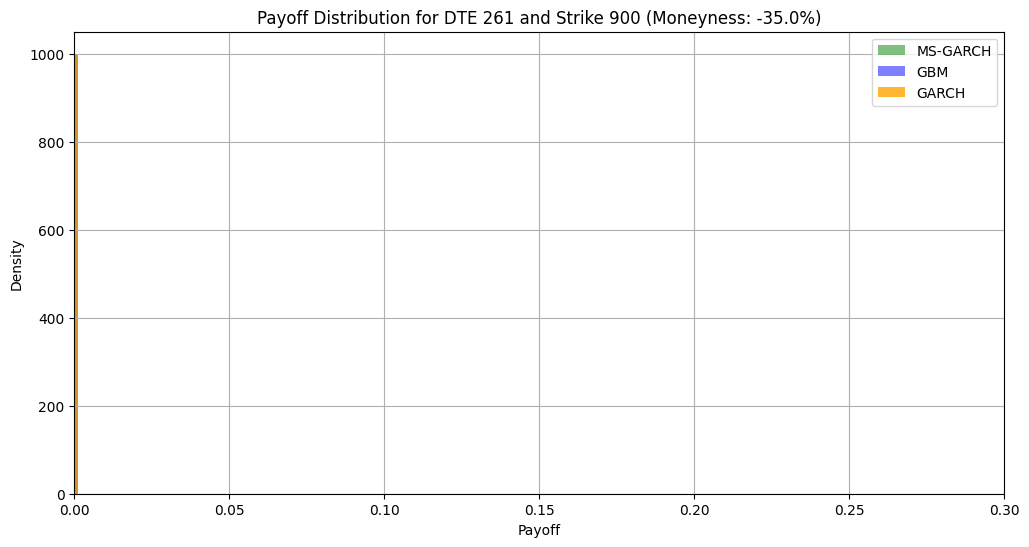

In [ ]:
K = 900 # at the money
#how to calculate moneyness? answer: 
moneyness = round((S0 - K) / K, 2)

# plot the payoff distribution for the three models
gbm_payoff = europe_call_payoff(gbm_finals, K)
garch_payoff = europe_call_payoff(garch_finals, K)
ms_garch_payoff = europe_call_payoff(ms_garch_finals, K)

plt.figure(figsize=(12, 6))
plt.hist(ms_garch_payoff, bins=1000, alpha=0.5, label='MS-GARCH', color='green', density=True)
plt.hist(gbm_payoff, bins=1000, alpha=0.5, label='GBM', color='blue', density=True)
plt.hist(garch_payoff, bins=1000, alpha=0.8, label='GARCH', color='orange', density=True)
plt.title(f"Payoff Distribution for DTE {dte} and Strike {K} (Moneyness: {moneyness*100}%)")
plt.xlabel("Payoff")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.xlim(0, 0.3)
plt.show()

In [ ]:
dte = 1
gbm_finals = gbm_dict[dte]
garch_finals = garch_dict[dte]
ms_garch_finals = ms_garch_dict[dte]

# get mean, var, skew and kurtosis in a dataframe
def get_stats(finals):
    mean = np.mean(finals)
    var = np.var(finals)
    skew = pd.Series(finals).skew()
    kurtosis = pd.Series(finals).kurtosis() + 3
    return mean, var, skew, kurtosis
gbm_mean, gbm_var, gbm_skew, gbm_kurtosis = get_stats(gbm_finals)
garch_mean, garch_var, garch_skew, garch_kurtosis = get_stats(garch_finals)
ms_garch_mean, ms_garch_var, ms_garch_skew, ms_garch_kurtosis = get_stats(ms_garch_finals)

stats_df = pd.DataFrame({
    'Model': ['GBM', 'GARCH', 'MS-GARCH'],
    'Mean': [gbm_mean, garch_mean, ms_garch_mean],
    'Variance': [gbm_var, garch_var, ms_garch_var],
    'Skewness': [gbm_skew, garch_skew, ms_garch_skew],
    'Kurtosis': [gbm_kurtosis, garch_kurtosis, ms_garch_kurtosis]
})
stats_df = stats_df.set_index('Model')
stats_df = stats_df.round(4)
stats_df

,Mean,Variance,Skewness,Kurtosis
Model,,,,
GBM,587.0188,46.5997,-0.0521,3.0188
GARCH,587.0800,44.8913,0.0287,3.0717
MS-GARCH,586.7628,104.4101,-0.1180,8.8203


In [ ]:
dte = 30
gbm_finals = gbm_dict[dte]
garch_finals = garch_dict[dte]
ms_garch_finals = ms_garch_dict[dte]

# get mean, var, skew and kurtosis in a dataframe
def get_stats(finals):
    mean = np.mean(finals)
    var = np.var(finals)
    skew = pd.Series(finals).skew()
    kurtosis = pd.Series(finals).kurtosis() + 3
    return mean, var, skew, kurtosis
gbm_mean, gbm_var, gbm_skew, gbm_kurtosis = get_stats(gbm_finals)
garch_mean, garch_var, garch_skew, garch_kurtosis = get_stats(garch_finals)
ms_garch_mean, ms_garch_var, ms_garch_skew, ms_garch_kurtosis = get_stats(ms_garch_finals)

stats_df = pd.DataFrame({
    'Model': ['GBM', 'GARCH', 'MS-GARCH'],
    'Mean': [gbm_mean, garch_mean, ms_garch_mean],
    'Variance': [gbm_var, garch_var, ms_garch_var],
    'Skewness': [gbm_skew, garch_skew, ms_garch_skew],
    'Kurtosis': [gbm_kurtosis, garch_kurtosis, ms_garch_kurtosis]
})
stats_df = stats_df.set_index('Model')
stats_df = stats_df.round(4)
stats_df

KeyError: 30

In [ ]:
dte = 961
gbm_finals = gbm_dict[dte]
garch_finals = garch_dict[dte]
ms_garch_finals = ms_garch_dict[dte]

# get mean, var, skew and kurtosis in a dataframe
def get_stats(finals):
    mean = np.mean(finals)
    var = np.var(finals)
    skew = pd.Series(finals).skew()
    kurtosis = pd.Series(finals).kurtosis() + 3
    return mean, var, skew, kurtosis
gbm_mean, gbm_var, gbm_skew, gbm_kurtosis = get_stats(gbm_finals)
garch_mean, garch_var, garch_skew, garch_kurtosis = get_stats(garch_finals)
ms_garch_mean, ms_garch_var, ms_garch_skew, ms_garch_kurtosis = get_stats(ms_garch_finals)

stats_df = pd.DataFrame({
    'Model': ['GBM', 'GARCH', 'MS-GARCH'],
    'Mean': [gbm_mean, garch_mean, ms_garch_mean],
    'Variance': [gbm_var, garch_var, ms_garch_var],
    'Skewness': [gbm_skew, garch_skew, ms_garch_skew],
    'Kurtosis': [gbm_kurtosis, garch_kurtosis, ms_garch_kurtosis]
})
stats_df = stats_df.set_index('Model')
stats_df = stats_df.round(4)
stats_df